# Table of Contents
- [데이터셋 살펴보기](#dataset-intro)
- [EAST 모델 학습을 위한 데이터 처리](#east-data-processing)
    - [Score Map 생성](#score-map-generation)
    - [Geometry Map 생성](#geo-map-generation)
- [학습된 모델로 추론하기](#model-inference)


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import os.path as osp
import json
import math
from glob import glob
from pprint import pprint

import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import cv2
import albumentations as A
import lanms
from albumentations.pytorch import ToTensorV2
from imageio import imread

from model import EAST
from detect import detect

# 1. 데이터셋 살펴보기 <a class="anchor" id="dataset-intro"></a>

별도로 제공한 `convert_mlt.py` 스크립트로 생성된 데이터셋을 불러오는데, 본 예시에서는 한글 샘플들만으로 구성된 subset인 `ICDAR17_Korean`을 이용함.

In [7]:
DATASET_DIR = '/data/datasets/ICDAR17_Korean'  # FIXME

### 어노테이션 살펴보기


어노테이션은 UFO에 맞춰 작성되어 있습니다. (UFO에 대한 자세한 설명은 이전 강의 내용을 참조)

어노테이션에는 다양한 정보가 포함되어 있는데, EAST 학습에 이용되는 정보는 아래와 같습니다.

1. `points`: word bounding box를 나타내는 좌표값
   - shape: (N, 4, 2)
2. `illegibility`: 식별이 어려운 글자인지의 여부
   - 너무 흐릿한 글자 또는 사람이 봤을때 읽기 어려운 글자
   - 일반적으로 `illegibility=True`인 글자 영역은 masking을 통해 학습에서 무시하도록 처리함.

In [8]:
ufo_fpath = osp.join(DATASET_DIR, 'ufo/train.json')
with open(ufo_fpath, 'r') as f:
    ufo_anno = json.load(f)

In [9]:
print(ufo_anno.keys())

dict_keys(['images'])


In [6]:
print(len(ufo_anno['images']))

536


### 일부 샘플들의 이름 확인

이미지 파일명을 샘플의 ID로 이용함.

In [10]:
sample_ids = sorted(ufo_anno['images'])
print(sample_ids[:10])

['img_1001.jpg', 'img_1002.jpg', 'img_1003.jpg', 'img_1004.jpg', 'img_1011.jpg', 'img_1015.jpg', 'img_1017.jpg', 'img_1019.jpg', 'img_1023.jpg', 'img_1024.jpg']


### 첫 번째 샘플에 대한 어노테이션 내용 확인

6개의 단어를 포함하고 있고, 모두 유효한(`illegibility=False`) 단어들임.

In [11]:
first_sample_id = sample_ids[0]
print(first_sample_id)
pprint(ufo_anno['images'][first_sample_id])

img_1001.jpg
{'img_h': 2448,
 'img_w': 1836,
 'license_tag': {'commercial': True,
                 'holder': None,
                 'public': True,
                 'type': 'CC-BY-SA',
                 'usability': True},
 'tags': None,
 'words': {'0': {'illegibility': False,
                 'language': ['ko'],
                 'orientation': 'Horizontal',
                 'points': [[80.0, 807.0],
                            [607.0, 812.0],
                            [592.0, 1037.0],
                            [126.0, 1037.0]],
                 'transcription': '얼음,',
                 'word_tags': None},
           '1': {'illegibility': False,
                 'language': ['ko'],
                 'orientation': 'Horizontal',
                 'points': [[678.0, 793.0],
                            [1160.0, 803.0],
                            [1155.0, 1037.0],
                            [691.0, 1037.0]],
                 'transcription': '석유',
                 'word_tags': None},
   

### 이미지와 어노테이션 정보 시각화

In [12]:
def draw_bbox(image, bbox, color=(0, 0, 255), thickness=1, thickness_sub=None, double_lined=False,
              write_point_numbers=False):
    """이미지에 하나의 bounding box를 그려넣는 함수
    """
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub,
                            thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness,
                        cv2.LINE_AA)


def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=1, thickness_sub=None,
                double_lined=False, write_point_numbers=False):
    """이미지에 다수의 bounding box들을 그려넣는 함수
    """
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness, thickness_sub=thickness_sub,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)
        

def gray_mask_to_heatmap(x):
    """생성할 gt가 grayscale가 많아서 좀 더 보기 좋게 시각화해주는 함수
    """
    x = cv2.cvtColor(cv2.applyColorMap(x, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    return x


def get_superimposed_image(image, score_map, heatmap=True, w_image=None, w_map=None):
    """이미지에 map/mask 등을 중첩하여 그려주는 함수
    gt와 비교해서 원하는 위치에 pred가 잘 생성됐는지 확인하는 함수
    
    Args:
        image (ndarray): (H, W, C) shaped, float32 or uint8 dtype is allowed.
        score_map (ndarray): (H, W) shaped, float32 or uint8 dtype is allowed.
        heatmap (boot): Wheather to convert `score_map` into a heatmap.
        w_image (float)
        w_map (float)

    Blending weights(`w_image` and `w_map`) are default to (0.4, 0.6).
    """

    assert w_image is None or (w_image > 0 and w_image < 1)
    assert w_map is None or (w_map > 0 and w_map < 1)

    if image.dtype != np.uint8:
        image = (255 * np.clip(image, 0, 1)).astype(np.uint8)

    if score_map.dtype != np.uint8:
        score_map = (255 * np.clip(score_map, 0, 1)).astype(np.uint8)
    if heatmap:
        score_map = gray_mask_to_heatmap(score_map)
    elif score_map.ndim == 2 or score_map.shape[2] != 3:
        score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2RGB)

    if w_image is None and w_map is None:
        w_image, w_map = 0.4, 0.6
    elif w_image is None:
        w_image = 1 - w_map
    elif w_map is None:
        w_map = 1 - w_image

    return cv2.addWeighted(image, w_image, score_map, w_map, 0)

### 예시로 특정 샘플 살펴보기

In [14]:
SAMPLE_IDX = 209

sample_id = sample_ids[SAMPLE_IDX]  # `sample_id`가 곧 이미지 파일명
image_fpath = osp.join(DATASET_DIR, 'images', sample_id)
image = imread(image_fpath)

print('Image:\t{}'.format(image.shape))

bboxes, labels = [], []
for word_info in ufo_anno['images'][sample_id]['words'].values():
    bboxes.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))
bboxes, labels = np.array(bboxes, dtype=np.float32), np.array(labels, dtype=np.float32)

print('Bounding boxes:\t{}'.format(bboxes.shape))
print('Labels:\t{}'.format(labels.shape))

Image:	(2448, 1836, 3)
Bounding boxes:	(5, 4, 2)
Labels:	(5,)


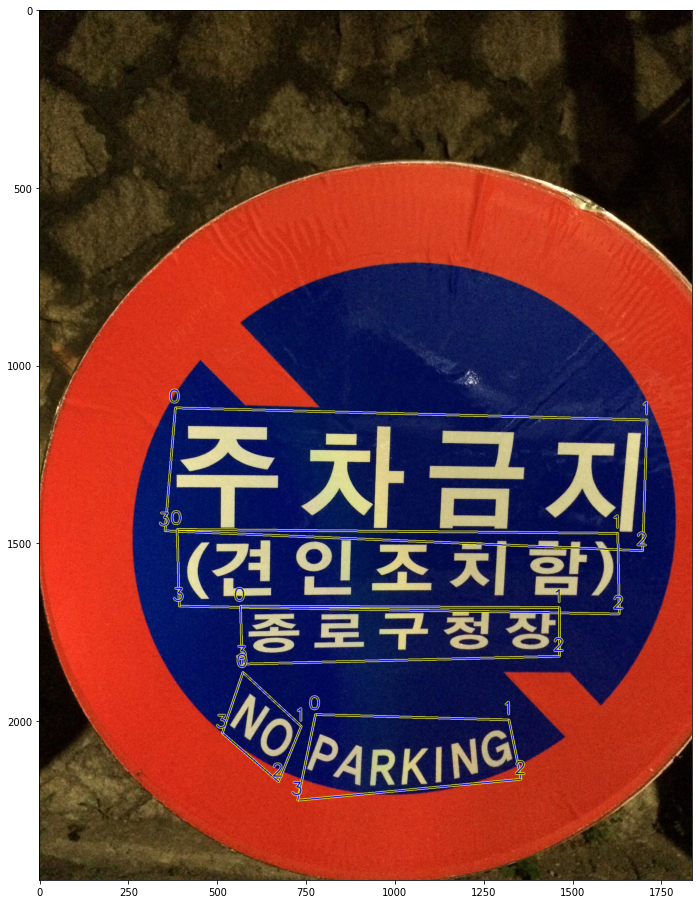

In [15]:
vis = image.copy()
draw_bboxes(vis, bboxes, double_lined=True, thickness=2, thickness_sub=5, write_point_numbers=True)

plt.figure(figsize=(16, 16))
plt.imshow(vis)

# 2. EAST 모델 학습을 위한 데이터 처리<a class="anchor" id="east-data-processing"></a>

EAST 검출기 모델 학습을 위해서는 2가지의 GT 레이블을 생성해야 함. (자세한 내용은 강의자료 참조)

1. Score map - 하나의 채널로 되어있는 map을 사용해서 각 word box의 중심 부분을 찾음
2. Geometry map - 5개의 채널로 되어있는 map을 사용해서 상, 하, 좌, 우 방향을 나타내는 map과 기울기 map을 찾음
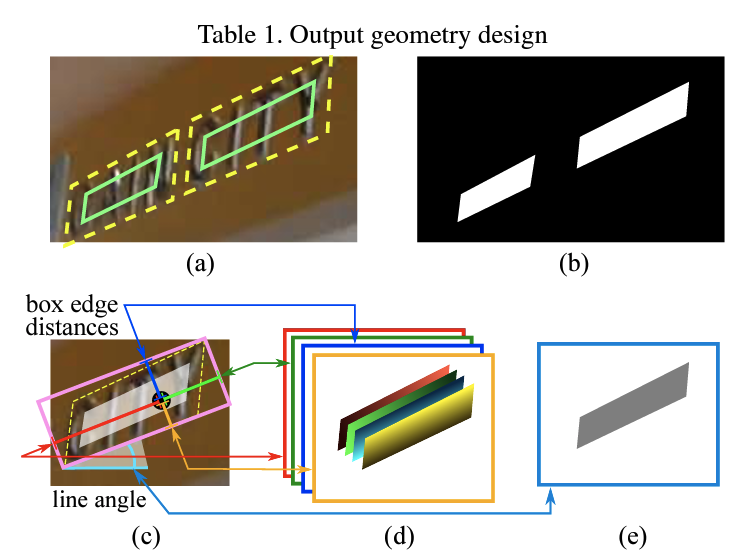

### 자세히 살펴보기 위해 특정 글자 영역 중심으로 RoI 설정

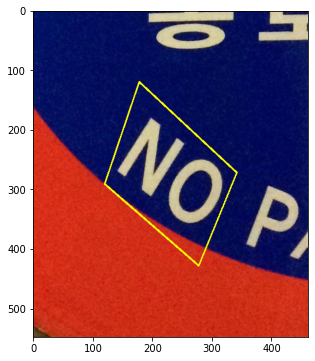

In [17]:
WORD_IDX = 3
VIEW_MARGIN = 120  # pixels
ROI_FIG_SIZE = (6, 6)

target_bbox = np.round(bboxes[WORD_IDX]).astype(np.int32)

x_min, y_min = np.min(target_bbox, axis=0)
x_max, y_max = np.max(target_bbox, axis=0)
src_points = np.array([[x_min - VIEW_MARGIN, y_min - VIEW_MARGIN],
                       [x_max + VIEW_MARGIN, y_min - VIEW_MARGIN],
                       [x_max + VIEW_MARGIN, y_max + VIEW_MARGIN],
                       [x_min - VIEW_MARGIN, y_max + VIEW_MARGIN]], dtype=np.float32)
dst_points = np.array([[0, 0],
                       [x_max - x_min + 2 * VIEW_MARGIN, 0],
                       [x_max - x_min + 2 * VIEW_MARGIN, y_max - y_min + 2 * VIEW_MARGIN],
                       [0, y_max - y_min + 2 * VIEW_MARGIN]], dtype=np.float32)
roi_patch = cv2.warpPerspective(
    image,
    cv2.getPerspectiveTransform(src_points, dst_points),
    dsize=(x_max - x_min + 2 * VIEW_MARGIN, y_max - y_min + 2 * VIEW_MARGIN),
)
target_bbox[:, 0] -= x_min - VIEW_MARGIN
target_bbox[:, 1] -= y_min - VIEW_MARGIN

vis = roi_patch.copy()
draw_bbox(vis, target_bbox, color=(255, 255, 0), thickness=2)

plt.figure(figsize=ROI_FIG_SIZE)
plt.imshow(vis)

## Score map 생성<a class="anchor" id="score-map-generation"></a>

가로/세로의 크기는 이미지(직전에 생성한 `roi_patch`)의 1/4

In [18]:
MAP_SCALE = 0.25
INV_MAP_SCALE = int(1 / MAP_SCALE)

print(f'{INV_MAP_SCALE=}')

INV_MAP_SCALE=4


### Score map 초기화

Image size: (548, 462, 3)
Score map size: (137, 115, 1)


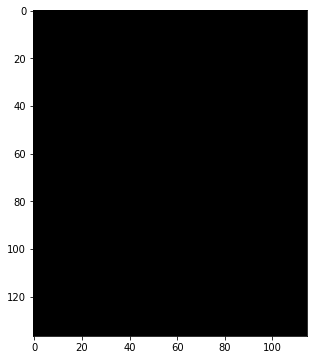

In [20]:
img_h, img_w = roi_patch.shape[:2]
map_h, map_w = int(img_h * MAP_SCALE), int(img_w * MAP_SCALE)

score_map = np.zeros((map_h, map_w, 1), np.float32)

print('Image size: {}'.format(roi_patch.shape))
print('Score map size: {}'.format(score_map.shape))

plt.figure(figsize=ROI_FIG_SIZE)
plt.imshow(score_map, cmap='gray')

### Bounding box shrinking 적용하여 Center region 계산

EAST는 bounding box의 전체 영역이 아니라 center region에 대한 segmentation을 수행하는 방식임.

In [21]:
def shrink_bbox(bbox, coef=0.3, inplace=False, max_sides=None):
    """Bounding box의 center region을 계산하는 함수
    """
    # 네 변의 길이 계산
    lens = [np.linalg.norm(bbox[i] - bbox[(i + 1) % 4], ord=2) for i in range(4)]
    r = [min(lens[(i - 1) % 4], lens[i]) for i in range(4)]
    
    if not inplace:
        bbox = bbox.copy()
    
    offset = 0 if lens[0] + lens[2] > lens[1] + lens[3] else 1
    cnt_moved = 0
    for idx in [0, 2, 1, 3]:
        if max_sides is not None and cnt_moved >= max_sides:
            break
            
        p1_idx, p2_idx = (idx + offset) % 4, (idx + 1 + offset) % 4
        p1p2 = bbox[p2_idx] - bbox[p1_idx]
        dist = np.linalg.norm(p1p2)
        if dist <= 1:
            continue
        bbox[p1_idx] = bbox[p1_idx] + p1p2 / dist * r[p1_idx] * coef
        bbox[p2_idx] = bbox[p2_idx] - p1p2 / dist * r[p2_idx] * coef
        cnt_moved += 1
        
    return bbox

### 가로/세로 중 긴 쪽부터 Shrinking 적용

`SHRINK_N_SIDES` 변경하면 중간 과정을 확인할 수 있음. (디버깅용)

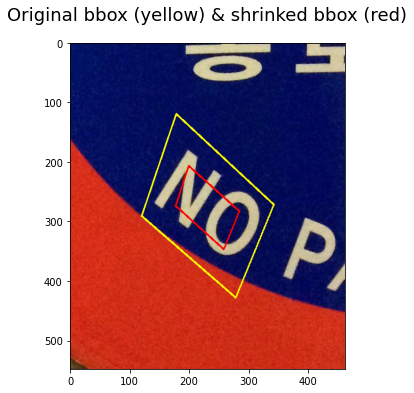

In [25]:
SHRINK_N_SIDES = 4  # FIXME [0, 1, 2, 3, 4]

shrunken_bbox = shrink_bbox(target_bbox, max_sides=SHRINK_N_SIDES)

vis = roi_patch.copy()
draw_bbox(vis, target_bbox, color=(255, 255, 0), thickness=2)
draw_bbox(vis, shrunken_bbox, color=(255, 0, 0), thickness=2)

plt.figure(figsize=ROI_FIG_SIZE)
plt.title('Original bbox (yellow) & shrinked bbox (red)', fontsize=18, y=1.05)
plt.imshow(vis)

### Shrunken BBOX로 Score map 생성

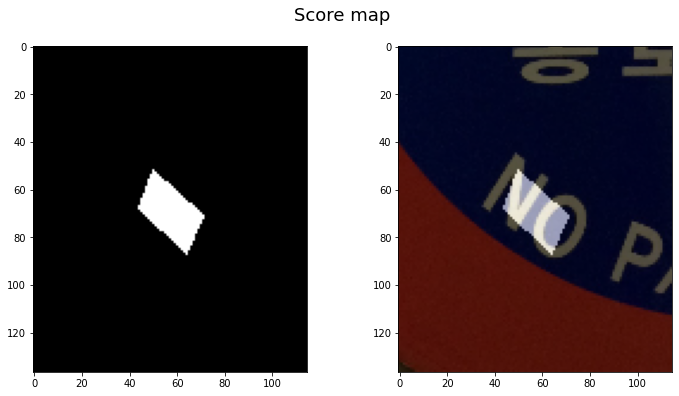

In [26]:
poly = np.round(MAP_SCALE * shrunken_bbox).astype(np.int32)
cv2.fillPoly(score_map, [poly], 1)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(ROI_FIG_SIZE[0] * 2, ROI_FIG_SIZE[1]))
plt.suptitle('Score map', fontsize=18, y=0.97)
axs[0].imshow(score_map, cmap='gray')
axs[1].imshow(get_superimposed_image(cv2.resize(roi_patch, dsize=(map_w, map_h)), score_map, heatmap=False))

## Geometry map 생성<a class="anchor" id="geo-map-generation"></a>

Score map과 마찬가지로 Geometry map 가로/세로의 크기는 이미지 크기의 1/4

5개 채널로 구성됨.

- 상/하/좌/우 방향으로 글자 영역의 경계선까지의 거리 예측: d1, d2, d3, d4
- 글자의 각도 예측: θ

Geometry map 을 생성하는 방법
1. Geometry Map 초기화
2. BBOX의 각도를 계산
3. BBOX 영역을 덮는 RBOX를 찾음
5. 찾은 RBOX와 각도를 활용하여 distance map과 angle map을 생성

### Geometry map 초기화

Image size: (548, 462, 3)
Geometry map: (137, 115, 5)


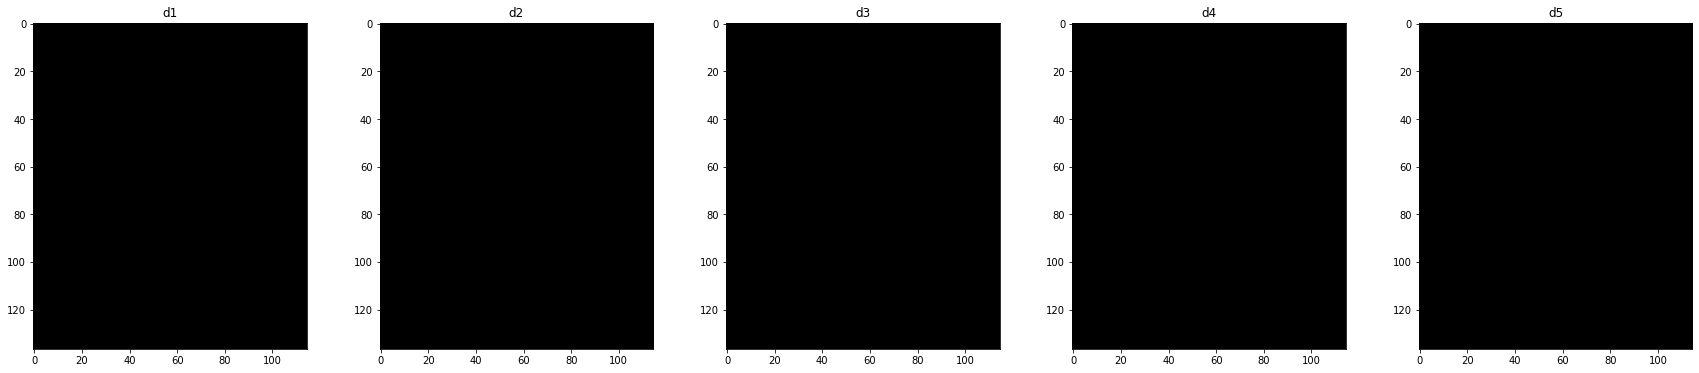

In [27]:
img_h, img_w = roi_patch.shape[:2]
map_h, map_w = int(img_h * MAP_SCALE), int(img_w * MAP_SCALE)

geo_map = np.zeros((map_h, map_w, 5), np.float32)

print('Image size: {}'.format(roi_patch.shape))
print('Geometry map: {}'.format(geo_map.shape))

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(ROI_FIG_SIZE[0] * 5, ROI_FIG_SIZE[1]))
for idx in range(5):
    axs[idx].title.set_text('d{}'.format(idx+1))
    axs[idx].imshow(geo_map[..., idx], cmap='gray')

### BBOX를 담고있는 RBOX를 찾아 각도 계산

In [29]:
def get_rotate_mat(theta):
    """주어진 각도에 대한 회전 변환 행렬을 계산하는 함수
    """
    return np.array([[math.cos(theta), -math.sin(theta)],
                     [math.sin(theta), math.cos(theta)]])


def calc_error_from_rect(bbox):
    """
    Default orientation is x1y1 : left-top, x2y2 : right-top, x3y3 : right-bot, x4y4 : left-bot.
    Calculate the difference between the vertices orientation and default orientation.
    """
    x_min, y_min = np.min(bbox, axis=0)
    x_max, y_max = np.max(bbox, axis=0)
    rect = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]],
                    dtype=np.float32)
    return np.linalg.norm(bbox - rect, axis=0).sum()


def rotate_bbox(bbox, theta, anchor=None):
    points = bbox.T
    if anchor is None:
        anchor = points[:, :1]
    rotated_points = np.dot(get_rotate_mat(theta), points - anchor) + anchor
    return rotated_points.T


def find_min_rect_angle(bbox, roi_image=None, visualize_angles=[], rank_num=10):
    """
    Find the best angle to rotate poly and obtain min rectangle.
    """
    
    angle_images = []
    
    areas = []
    angles = np.arange(-90, 91) / 180 * math.pi
    for theta in angles:
        rotated_bbox = rotate_bbox(bbox, theta)
        x_min, y_min = np.min(rotated_bbox, axis=0)
        x_max, y_max = np.max(rotated_bbox, axis=0)
        areas.append((x_max - x_min) * (y_max - y_min))
        
        if visualize_angles and np.rad2deg(theta) in visualize_angles:

            rotated_minmax_box = np.array([
                [x_min, y_min],
                [x_max, y_min],
                [x_max, y_max],
                [x_min, y_max]
            ])
            
            vis = roi_image.copy()            
            draw_bbox(vis, rotated_bbox, color=(255, 255, 0), thickness=2)
            draw_bbox(vis, rotated_minmax_box, color=(255, 0, 0), thickness=2)
            
            angle_images.append(vis)
    
    if angle_images:
        if len(angle_images) == 1:
            plt.figure(figsize=ROI_FIG_SIZE)
            plt.title('{}'.format(visualize_angles[0]))
            plt.imshow(vis)
        else:
            fig, axs = plt.subplots(
                nrows=1, ncols=len(angle_images),   
                figsize=(ROI_FIG_SIZE[0] * len(angle_images), ROI_FIG_SIZE[1]))
            for idx in range(len(angle_images)):
                axs[idx].title.set_text('{}'.format(visualize_angles[idx]))
                axs[idx].imshow(angle_images[idx], cmap='gray')
            
    best_angle, min_error = -1, float('inf')
    for idx in np.argsort(areas)[:rank_num]:
        rotated_bbox = rotate_bbox(bbox, angles[idx])
        error = calc_error_from_rect(rotated_bbox)
        if error < min_error:
            best_angle, min_error = angles[idx], error

    return best_angle

(-1.0, 1.0)

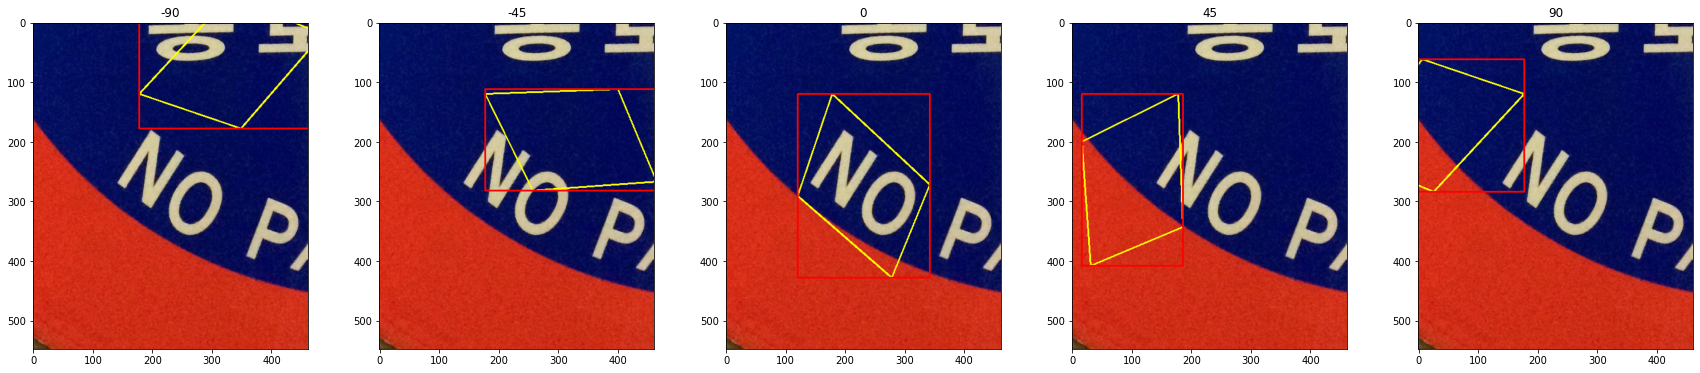

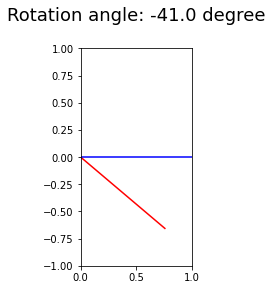

In [35]:
theta = find_min_rect_angle(target_bbox, roi_image=roi_patch, visualize_angles=[-90, -45, 0, 45, 90])
degree_angle = np.rad2deg(theta)

plt.figure(figsize=(2, 4))
plt.plot([0, math.cos(theta)], [0, math.sin(theta)], 'r-')
plt.plot([0, math.cos(0)], [0, math.sin(0)], 'b-')
plt.title('Rotation angle: {} degree'.format(theta * 180 / math.pi), fontsize=18, y=1.1)
plt.xlim([0, 1])
plt.ylim([-1, 1])

### GT BBOX를 RBOX 형태로 변환해보기

각 픽셀에서의 RBOX의 네 변에 대한 거리가 Distance map(d1, d2, d3, d4)을 구성하는 값이 됨.

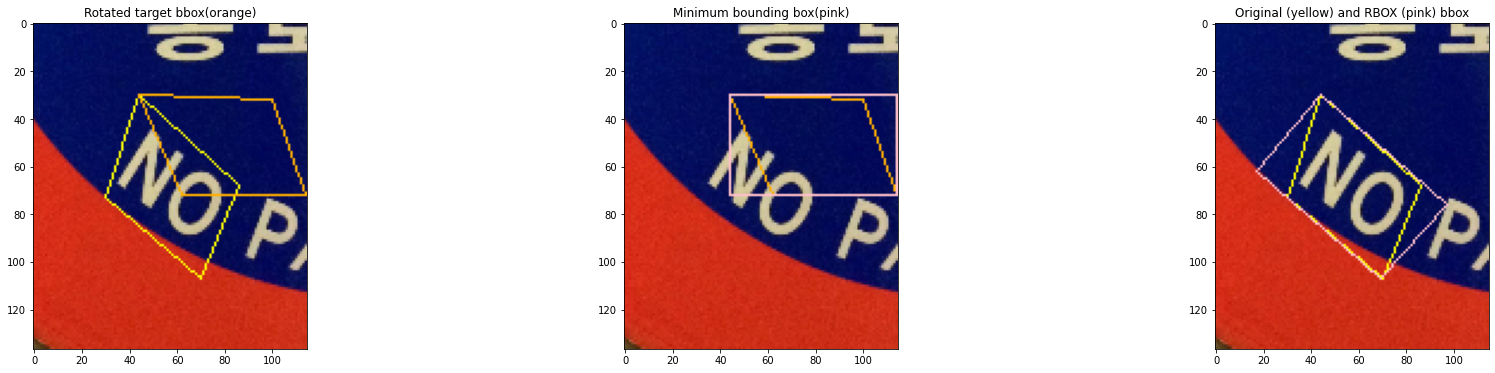

In [36]:
center_mask = np.zeros((map_h, map_w), np.float32)
poly = np.round(MAP_SCALE * shrunken_bbox).astype(np.int32)
cv2.fillPoly(center_mask, [poly], 1)

rotated_bbox = rotate_bbox(target_bbox, theta)
rotated_bbox *= MAP_SCALE

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(ROI_FIG_SIZE[0] * 5, ROI_FIG_SIZE[1]))

vis = cv2.resize(roi_patch, dsize=(map_w, map_h))
draw_bbox(vis, target_bbox * MAP_SCALE, color=(255, 255, 0))
draw_bbox(vis, rotated_bbox, color=(255, 175, 0))
axs[0].title.set_text('Rotated target bbox(orange)')
axs[0].imshow(vis)

rotated_bbox_x_min, rotated_bbox_y_min = np.min(rotated_bbox, axis=0)
rotated_bbox_x_max, rotated_bbox_y_max = np.max(rotated_bbox, axis=0)

gt_rbox = np.array([
    [rotated_bbox_x_min, rotated_bbox_y_min], 
    [rotated_bbox_x_max, rotated_bbox_y_min], 
    [rotated_bbox_x_max, rotated_bbox_y_max], 
    [rotated_bbox_x_min, rotated_bbox_y_max]],
    dtype=np.float32)

vis = cv2.resize(roi_patch, dsize=(map_w, map_h))
draw_bbox(vis, rotated_bbox, color=(255, 175, 0))
draw_bbox(vis, gt_rbox, color=(255, 192, 203))
axs[1].title.set_text('Minimum bounding box(pink)')
axs[1].imshow(vis)

gt_rbox = rotate_bbox(gt_rbox, -theta)

vis = cv2.resize(roi_patch, dsize=(map_w, map_h))
draw_bbox(vis, target_bbox * MAP_SCALE, color=(255, 255, 0))
draw_bbox(vis, gt_rbox, color=(255, 192, 203))

axs[2].title.set_text('Original (yellow) and RBOX (pink) bbox')
axs[2].imshow(vis)

### Distance map(d1, d2, d3, d4) 생성

Bounding box의 각도만큼 회전된 축 상에서 두 축을 따라 값이 선형적으로 증가하는 Map을 각각 생성합니다. 

#### Distance map 생성 과정 요약  
1. 아무것도 없는 canvas에 linear하게 증가하는 distance map 생성 (angle, rbox 정보 x)
2. angle theta 정보를 활용해 distance map을 회전시켜줌 (anchor로는 bbox top left point 사용)
3. 돌아가있는 distance map을 box 정보를 활용해서 box 위치로 옮겨줌 (min/max_x, min/max_y 값 활용)
4. shrinked bbox를 사용해서 score map 영역에 해당되는 pixel들에만 distance map 생성

### 1. 간단한 distance map 생성

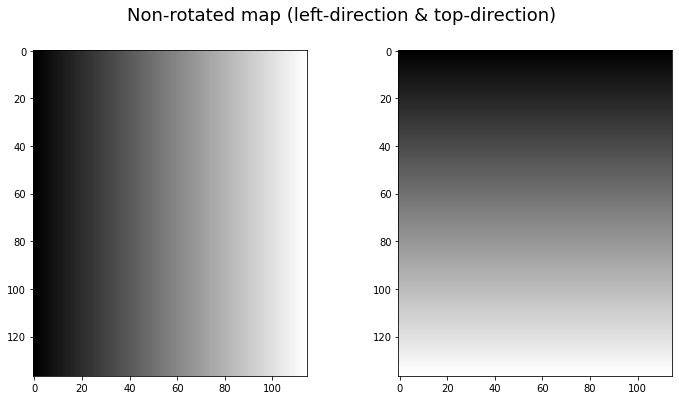

In [37]:
def get_rotated_coords(h, w, theta, anchor):
    anchor = anchor.reshape(2, 1)
    rotate_mat = get_rotate_mat(theta)
    
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    x_lin = x.reshape((1, x.size))
    y_lin = y.reshape((1, x.size))
    
    coord_mat = np.concatenate((x_lin, y_lin), 0)
    rotated_coord = np.dot(rotate_mat, coord_mat - anchor) + anchor
    
    rotated_x = rotated_coord[0, :].reshape(x.shape)
    rotated_y = rotated_coord[1, :].reshape(y.shape)
    return rotated_x, rotated_y

### DRAW NON-ROTATED DISTANCE MAP ###
# generate non-rotated coordinates
non_rotated_x, non_rotated_y = get_rotated_coords(map_h, map_w, 0, target_bbox[0] * MAP_SCALE)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(ROI_FIG_SIZE[0] * 2, ROI_FIG_SIZE[1]))
plt.suptitle('Non-rotated map (left-direction & top-direction)', fontsize=18)
axs[0].imshow(non_rotated_x, cmap='gray')
axs[1].imshow(non_rotated_y, cmap='gray')

### 2. Rotated distance map 생성

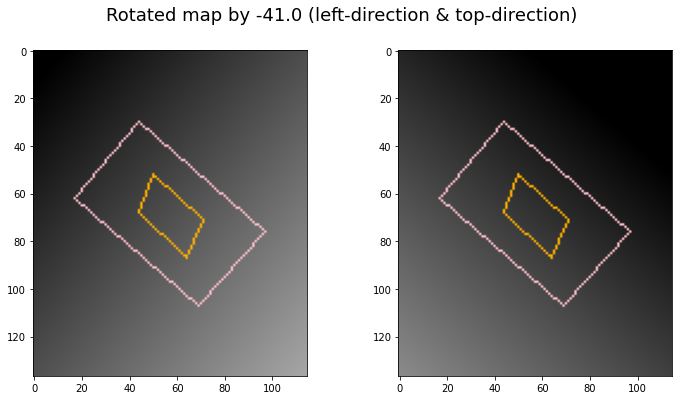

In [41]:
### DRAW ROTATED DISTANCE MAP ###
# generate rotated coordinates by theta
rotated_x, rotated_y = get_rotated_coords(map_h, map_w, theta, target_bbox[0] * MAP_SCALE)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(ROI_FIG_SIZE[0] * 2, ROI_FIG_SIZE[1]))
plt.suptitle('Rotated map by {} (left-direction & top-direction)'.format(degree_angle), fontsize=18)

# draw rbox, shrunken_bbox with the rotated distance map in left-direction
vis_rotated_x = rotated_x.copy()

# 돌아가면서 음수로 변하는 영역 0으로 처리 (visualization 위해)
vis_rotated_x[vis_rotated_x<0] = 0

vis_rotated_x = cv2.cvtColor((vis_rotated_x).astype(np.uint8), cv2.COLOR_GRAY2BGR)
draw_bbox(vis_rotated_x, shrunken_bbox*MAP_SCALE, color=(255, 175, 0))
draw_bbox(vis_rotated_x, gt_rbox, color=(255, 192, 203))

# draw rbox, shrunken_bbox with the rotated distance map in top-direction 
vis_rotated_y = rotated_y.copy()

# 돌아가면서 음수로 변하는 영역 0으로 처리 (visualization 위해)
vis_rotated_y[vis_rotated_y<0] = 0

vis_rotated_y = cv2.cvtColor((vis_rotated_y).astype(np.uint8), cv2.COLOR_GRAY2BGR)
draw_bbox(vis_rotated_y, shrunken_bbox*MAP_SCALE, color=(255, 175, 0))
draw_bbox(vis_rotated_y, gt_rbox, color=(255, 192, 203))

axs[0].imshow(vis_rotated_x)
axs[1].imshow(vis_rotated_y)

### 3. Rotated + Shifted distance map 생성

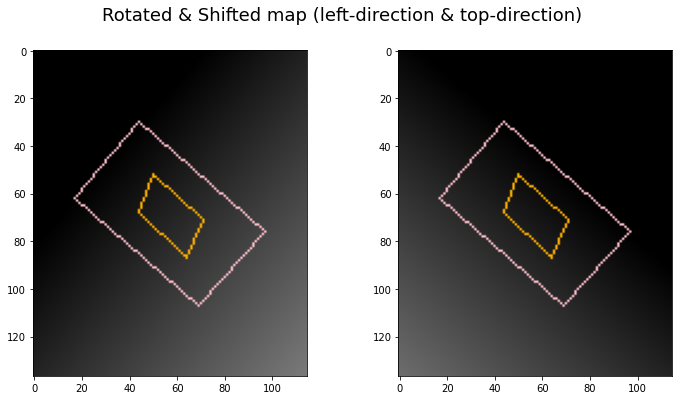

In [42]:
### DRAW ROTATED + SHIFTED DISTANCE MAP ###
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(ROI_FIG_SIZE[0] * 2, ROI_FIG_SIZE[1]))
plt.suptitle('Rotated & Shifted map (left-direction & top-direction)'.format(degree_angle), fontsize=18)

# draw rbox, shrunken_bbox with the rotated distance map in left-direction
vis_rotated_x = rotated_x.copy()

# rotated_bbox_x_min 을 사용하여 좌측 시작 변의 값을 0으로 만들어줌
vis_rotated_x -= rotated_bbox_x_min

# rotation + shift 적용되면서 음수로 변하는 영역 0으로 처리 (visualization 위해)
vis_rotated_x[vis_rotated_x<0] = 0

vis_rotated_x = cv2.cvtColor((vis_rotated_x).astype(np.uint8), cv2.COLOR_GRAY2BGR)
draw_bbox(vis_rotated_x, shrunken_bbox*MAP_SCALE, color=(255, 175, 0))
draw_bbox(vis_rotated_x, gt_rbox, color=(255, 192, 203))

# draw rbox, shrunken_bbox with the rotated distance map in top-direction 
vis_rotated_y = rotated_y.copy()

# rotated_bbox_x_min 을 사용하여 상단 시작 변의 값을 0으로 만들어줌
vis_rotated_y -= rotated_bbox_y_min

# rotation + shift 적용되면서 음수로 변하는 영역 0으로 처리 (visualization 위해)
vis_rotated_y[vis_rotated_y<0] = 0
vis_rotated_y = cv2.cvtColor((vis_rotated_y).astype(np.uint8), cv2.COLOR_GRAY2BGR)
draw_bbox(vis_rotated_y, shrunken_bbox*MAP_SCALE, color=(255, 175, 0))
draw_bbox(vis_rotated_y, gt_rbox, color=(255, 192, 203))

axs[0].imshow(vis_rotated_x)
axs[1].imshow(vis_rotated_y)

### 4. Score map 영역을 mask로 활용하여 distance map 영역 설정

In [ ]:
### DRAW ROTATED + SHIFTED DISTANCE MAP ###
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(ROI_FIG_SIZE[0] * 2, ROI_FIG_SIZE[1]))
plt.suptitle('Masked distance map (left-direction & top-direction)'.format(degree_angle), fontsize=18)

# draw rbox, shrunken_bbox with the rotated distance map in left-direction
vis_rotated_x = rotated_x.copy()
vis_rotated_x -= rotated_bbox_x_min
vis_rotated_x[vis_rotated_x<0] = 0
vis_rotated_x *= score_map[:, :, 0]

# draw rbox, shrunken_bbox with the rotated distance map in top-direction 
vis_rotated_y = rotated_y.copy()
vis_rotated_y -= rotated_bbox_y_min
vis_rotated_y[vis_rotated_y<0] = 0
vis_rotated_y *= score_map[:, :, 0]

axs[0].imshow(vis_rotated_x, cmap='gray')
axs[1].imshow(vis_rotated_y, cmap='gray')

### 박스 위치에 모든 Distance map(d1, d2, d3, d4) 생성

In [ ]:
# shift the pixels in the rotated map to the box position
shifted_d1, shifted_d2 = rotated_y - rotated_bbox_y_min, rotated_bbox_y_max - rotated_y
shifted_d1[shifted_d1 < 0] = 0
shifted_d2[shifted_d2 < 0] = 0
shifted_d3, shifted_d4 = rotated_x - rotated_bbox_x_min, rotated_bbox_x_max - rotated_x
shifted_d3[shifted_d3 < 0] = 0
shifted_d4[shifted_d4 < 0] = 0

d_maps = [shifted_d1, shifted_d2, shifted_d3, shifted_d4]

# apply score map 
geo_map[:, :, 0] += shifted_d1 * center_mask * INV_MAP_SCALE
geo_map[:, :, 1] += shifted_d2 * center_mask * INV_MAP_SCALE
geo_map[:, :, 2] += shifted_d3 * center_mask * INV_MAP_SCALE
geo_map[:, :, 3] += shifted_d4 * center_mask * INV_MAP_SCALE

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Geometry maps \nTOP(d1), BOTTM(d2), LEFT(d3), RIGHT(d4)', fontsize=18)

# visualize non-rotated maps
non_rotated_maps = [non_rotated_y, -non_rotated_y, non_rotated_x, -non_rotated_x]    
for idx in range(4):
    axs[0][idx].imshow(non_rotated_maps[idx], cmap='gray')

# visualize rotated distance map based on rotated box top left point
rotated_maps = [rotated_y, -rotated_y, rotated_x, -rotated_x]    
for idx in range(4):
    axs[1][idx].imshow(rotated_maps[idx], cmap='gray')

# visualize rotated + shifted distance map based on rotated box top left point
for idx in range(4):
    axs[2][idx].imshow(d_maps[idx], cmap='gray')
    
# visualize masked distance map using previously generated scoremap    
for idx in range(4):
    axs[3][idx].imshow(geo_map[:, :, idx], cmap='gray')

### 박스 위치에 Angle map(θ) 생성

In [ ]:
print(theta)
geo_map[:, :, 4] += theta * center_mask

plt.figure(figsize=ROI_FIG_SIZE)
plt.title('Geometry map (θ)', fontsize=18, y=1.05)
plt.imshow(geo_map[:, :, 4])

### Distance map 시각화

시각화를 위해 d1, d2, d3, d4의 값을 [0, 1]의 값으로 조절함. (학습에는 원본 버전을 이용)

In [ ]:
def normalize_geo_map(geo_map):
    """
    Use this method for visualization purposes only.
    """
    geo_map = geo_map.copy()
    for channel in range(4):
        num_blobs, idx_map = cv2.connectedComponents(np.array(geo_map[:, :, channel] > 0, dtype=np.uint8))
        for blob_idx in range(1, num_blobs):
            blob_region = idx_map == blob_idx
            geo_map[:, :, channel][blob_region] /= geo_map[:, :, channel][blob_region].max()
    return (geo_map * 255).astype(np.uint8)

In [ ]:
img = cv2.resize(roi_patch, dsize=(score_map.shape[1], score_map.shape[0]))
vis_geo_map = normalize_geo_map(geo_map)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Normalized geometry map (d1, d2, d3, d4)', fontsize=18)
for idx in range(4):
    axs[idx].imshow(get_superimposed_image(img, vis_geo_map[:, :, idx], w_map=0.8))

### GT RBOX 영역 내의 Geometry map을 시각화해봅니다.

In [ ]:
geo_map_rbox = np.zeros((map_h, map_w, 5), np.float32)

x_min, y_min = np.min(rotated_bbox, axis=0)
x_max, y_max = np.max(rotated_bbox, axis=0)

gt_rbox = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]],
                   dtype=np.float32)
gt_rbox = rotate_bbox(gt_rbox, -theta)
gt_rbox_mask = np.zeros((map_h, map_w), np.float32)
cv2.fillPoly(gt_rbox_mask, [np.round(gt_rbox).astype(np.int32)], 1)

geo_map_rbox[:, :, 0] += shifted_d1 * gt_rbox_mask * INV_MAP_SCALE
geo_map_rbox[:, :, 1] += shifted_d2 * gt_rbox_mask * INV_MAP_SCALE
geo_map_rbox[:, :, 2] += shifted_d3 * gt_rbox_mask * INV_MAP_SCALE
geo_map_rbox[:, :, 3] += shifted_d4 * gt_rbox_mask * INV_MAP_SCALE

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Geometry map (GT area)', fontsize=18)
for idx in range(4):
    axs[idx].imshow(geo_map_rbox[:, :, idx], cmap='gray')
    
img = cv2.resize(roi_patch, dsize=(score_map.shape[1], score_map.shape[0]))
vis_geo_map_rbox = normalize_geo_map(geo_map_rbox)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Normalized geometry map (GT area)', fontsize=18)
for idx in range(4):
    axs[idx].imshow(get_superimposed_image(img, vis_geo_map_rbox[:, :, idx], w_map=0.8))

### 모든 글자 영역에 대해 각각 score_map, geometry_map, angle_map을 만들어주는 과정을 수행 -> 한 샘플에 대한 GT를 생성

In [ ]:
MAP_SCALE = 0.25
INV_MAP_SCALE = int(1 / MAP_SCALE)

img_h, img_w = image.shape[:2]
map_h, map_w = int(img_h * MAP_SCALE), int(img_w * MAP_SCALE)

score_map = np.zeros((map_h, map_w, 1), np.float32)
geo_map = np.zeros((map_h, map_w, 5), np.float32)

print('Image:\t\t{}'.format(image.shape))
print('Score map:\t{}'.format(score_map.shape))
print('Geometry map:\t{}'.format(geo_map.shape))

word_polys = []

for bbox in bboxes:
    poly = np.around(MAP_SCALE * shrink_bbox(bbox)).astype(np.int32)
    word_polys.append(poly)
    
    center_mask = np.zeros((map_h, map_w), np.float32)
    cv2.fillPoly(center_mask, [poly], 1)

    theta = find_min_rect_angle(bbox)
    rotated_bbox = rotate_bbox(bbox, theta)
    rotated_bbox *= MAP_SCALE
    rotated_bbox_x_min, rotated_bbox_y_min = np.min(rotated_bbox, axis=0)
    rotated_bbox_x_max, rotated_bbox_y_max = np.max(rotated_bbox, axis=0)

    rotated_x, rotated_y = get_rotated_coords(map_h, map_w, theta, bbox[0] * MAP_SCALE)

    d1, d2 = rotated_y - rotated_bbox_y_min, rotated_bbox_y_max - rotated_y
    d1[d1 < 0] = 0
    d2[d2 < 0] = 0
    d3, d4 = rotated_x - rotated_bbox_x_min, rotated_bbox_x_max - rotated_x
    d3[d3 < 0] = 0
    d4[d4 < 0] = 0
    geo_map[:, :, 0] += d1 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 1] += d2 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 2] += d3 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 3] += d4 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 4] += theta * center_mask

cv2.fillPoly(score_map, word_polys, 1)


img = cv2.resize(image, dsize=(score_map.shape[1], score_map.shape[0]))
vis_geo_map = normalize_geo_map(geo_map)


# Plot figures

fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(24, 10))
plt.suptitle('EAST GT maps', fontsize=18, y=0.78)
axs = axs.flatten()
for x in axs:
    x.axis('off')
fig.tight_layout()
axs[0].imshow(get_superimposed_image(img, score_map, heatmap=False))
for idx in range(4):
    axs[idx + 1].imshow(get_superimposed_image(img, vis_geo_map[:, :, idx], w_map=0.8))
axs[5].imshow(vis_geo_map[:, :, 4])

# 3. 학습된 모델로 추론하기<a class="anchor" id="model-inference"></a>

In [ ]:
model = EAST(pretrained=False)
# model = model.cuda()
_ = model.eval()

In [ ]:
model.load_state_dict(torch.load('./trained_models_All/model_epoch_200.pth', map_location='cpu'))

### 대상 이미지를 불러옵니다.

In [ ]:
SAMPLE_IDX = 0
FIG_SIZE = (8, 8)

image = imread('test_images/image_02.png')
orig_size = image.shape[:2]

# image_fnames = sorted(ufo_anno['images'].keys())
# image_fname = image_fnames[SAMPLE_IDX]
# image_fpath = osp.join(DATASET_DIR, 'images', image_fname)
# image = imread(image_fpath)

print('Original image:\t{}'.format(image.shape))

plt.figure(figsize=FIG_SIZE)
plt.imshow(image)

### 이미지 입력을 일정 크기로 조정 (전처리)

In [ ]:
INPUT_SIZE = 1024

prep_fn = A.Compose([
    A.LongestMaxSize(INPUT_SIZE),
    A.PadIfNeeded(min_height=INPUT_SIZE, min_width=INPUT_SIZE, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(), ToTensorV2()
])

# 시각화를 위해 Normalize와 Tensorize를 제외한 버전
prep_fn_vis = A.Compose([
    A.LongestMaxSize(INPUT_SIZE),
    A.PadIfNeeded(min_height=INPUT_SIZE, min_width=INPUT_SIZE, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT)
])

vis = prep_fn_vis(image=image)['image']
plt.figure(figsize=FIG_SIZE)
plt.imshow(vis)

### 검출 결과 확인

In [ ]:
bboxes = detect(model, [image], INPUT_SIZE)[0]

vis = image.copy()
draw_bboxes(vis, bboxes, thickness=2)

plt.figure(figsize=FIG_SIZE)
plt.imshow(vis)

### 모델이 예측한 Map들을 시각화

In [ ]:
SCORE_THRES = 0.9

device = list(model.parameters())[0].device
batch = torch.stack([prep_fn(image=image)['image']], dim=0).to(device)

with torch.no_grad():
    score_maps, geo_maps = model(batch)
score_maps, geo_maps = score_maps.cpu().numpy(), geo_maps.cpu().numpy()
score_map, geo_map = score_maps[0], geo_maps[0]
score_map, geo_map = score_map.transpose(1, 2, 0), geo_map.transpose(1, 2, 0)
score_map = score_map.squeeze()

map_margin = int(abs(orig_size[0] - orig_size[1]) * MAP_SCALE * INPUT_SIZE / max(orig_size))
if map_margin > 0:
    if orig_size[0] > orig_size[1]:
        score_map[:, -map_margin:] = 0
        geo_map[:, -map_margin:, :] = 0
    else:
        score_map[-map_margin:, :] = 0
        geo_map[-map_margin:, :, :] = 0

fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(FIG_SIZE[0] * 6, FIG_SIZE[1]))
axs[0].imshow(score_map, cmap='gray')
for idx in range(4):
    axs[idx + 1].imshow(geo_map[:, :, idx], cmap='jet')
axs[5].imshow(geo_map[:, :, 4])


center_mask = score_map > SCORE_THRES
fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(FIG_SIZE[0] * 6, FIG_SIZE[1]))
axs[0].imshow(center_mask, cmap='gray')
for idx in range(4):
    axs[idx + 1].imshow(geo_map[:, :, idx] * center_mask, cmap='jet')
axs[5].imshow(geo_map[:, :, 4] * center_mask)

print('Original image:\t{}'.format(image.shape))
print('Input image:\t{}'.format(batch[0].shape))
print('Score map:\t{}'.format(score_map.shape))
print('Geometry map:\t{}'.format(geo_map.shape))

### 예측한 Score map과 Geometry map으로부터 Bounding box를 구하는 과정
1. confident한 score map 영역을 찾음
2. valid한 score map에 위치해 있는 각 point들을 iterate 하면서  
    a. point에 위치한 distance map(d1, d2, d3, d4) 값을 사용하여 정방향으로 되어있는 box를 찾음  
    b. point에 위치한 angle map(theta) 값을 사용하여 정방향 box를 돌려줌

In [ ]:
visualize_single_sample = True
SAMPLE_POINT_IDX = 200

NMS_THRES = 0.2

xy_text = np.argwhere(score_map > SCORE_THRES)[:, ::-1].copy()  # (n x 2)

if xy_text.size == 0:
    bboxes = np.zeros((0, 4, 2), dtype=np.float32)
else:
    xy_text = xy_text[np.argsort(xy_text[:, 1])]  # Row-wise로 정렬
    valid_pos = xy_text * INV_MAP_SCALE
    valid_geo = geo_map[xy_text[:, 1], xy_text[:, 0], :]  # (n x 5)
    
    indices, bboxes = [], []
    for idx, ((x, y), g) in enumerate(zip(valid_pos, valid_geo)):
        y_min, y_max = y - g[0], y + g[1]
        x_min, x_max = x - g[2], x + g[3]
        rotate_mat = get_rotate_mat(-g[4])
        
        bbox = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]], dtype=np.float32)
        anchor = np.array([x, y], dtype=np.float32).reshape(2, 1)
        rotated_bbox = (np.dot(rotate_mat, bbox.T - anchor) + anchor).T
        
        if visualize_single_sample and idx == SAMPLE_POINT_IDX:
            vis = score_map.copy() * 255
            vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2RGB).astype(np.uint8)
            draw_bboxes(vis, bbox.reshape(-1, 4, 2) * MAP_SCALE, thickness=2)
            draw_bboxes(vis, rotated_bbox.reshape(-1, 4, 2) * MAP_SCALE, color=(0, 255, 0), thickness=2)
            ref_point = np.array([x, y]) * MAP_SCALE
            cv2.circle(vis, (int(ref_point[0]), int(ref_point[1])), 2, (255, 0 ,0), 2)
            plt.figure(figsize=FIG_SIZE)
            plt.imshow(vis)
        
        # 이미지 범위에서 벗어나는 bbox는 탈락
        if bbox[:, 0].min() < 0 or bbox[:, 0].max() >= score_map.shape[1] * INV_MAP_SCALE:
            continue
        elif bbox[:, 1].min() < 0 or bbox[:, 1].max() >= score_map.shape[0] * INV_MAP_SCALE:
            continue

        indices.append(idx)
        bboxes.append(rotated_bbox.flatten())
    bboxes = np.array(bboxes)
    
    raw_bboxes = bboxes.reshape(-1, 4, 2)
    
    # 좌표 정보에 Score map에서 가져온 Score를 추가
    scored_bboxes = np.zeros((bboxes.shape[0], 9), dtype=np.float32)
    scored_bboxes[:, :8] = bboxes
    scored_bboxes[:, 8] = score_map[xy_text[indices, 1], xy_text[indices, 0]]
    
    # LA-NMS 적용
    nms_bboxes = lanms.merge_quadrangle_n9(scored_bboxes.astype('float32'), NMS_THRES)
    nms_bboxes = nms_bboxes[:, :8].reshape(-1, 4, 2)
    
    # 원본 이미지 크기에 맞게 bbox 크기 보정
    raw_bboxes *= max(orig_size) / INPUT_SIZE
    nms_bboxes *= max(orig_size) / INPUT_SIZE

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1]))
plt.suptitle('Before & After NMS Process', fontsize=18, y=0.95)

vis = image.copy()
draw_bboxes(vis, raw_bboxes[::], thickness=2)
axs[0].imshow(vis)

vis = image.copy()
draw_bboxes(vis, nms_bboxes, thickness=2)
axs[1].imshow(vis)

## GT 데이터 생성시 마주할 수 있는 상황들 
a.k.a 성능에 영향을 줄 수도 있는 부분들
1. Crop augmentation이 적용되면서 일부 텍스트만 들어오는 경우 어떻게 처리해야 할지?
2. 대부분의 텍스트 인스턴스들은 가로 방향으로 되어있는데 세로 방향의 텍스트를 잘 찾게 하기 위해 어떤 방법을 사용 할 수 있을지?
3. 겹쳐져있는 텍스트들도 있는데 GT를 어떻게 만들어서 학습해야 할지?
4. EAST 모델에서 Curved text region은 어떻게 핸들링 하는게 좋을지?